In [1]:
from o2s.models.object_2_sphere import Mesh2Sphere
from o2s.datasets.radar_dataset import RadarDataset

import numpy as np
import matplotlib.pyplot as plt
from torch_harmonics import plotting
from torch_geometric.loader import DataLoader
import xarray
import torch
from torch import nn

In [2]:
dataset = RadarDataset('/home/colin/hdd/workspace/datasets/test_dataset.nc', 'test', return_mesh=True)

In [3]:
B = 1
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)

In [4]:
model = Mesh2Sphere(5, 75, 128, 10.0, use_mlp=False).cuda()

/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/home/colin/anaconda3/envs/torch/lib/python3.10/site-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/

In [5]:
batch, resp, vert, face = next(iter(dataloader))

In [6]:
batch

DataBatch(x=[63, 1], edge_index=[2, 180], pos=[63, 3], edge_vec=[180, 3], batch=[63], ptr=[2])

In [7]:
pred, w = model(batch.cuda())

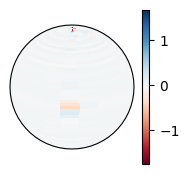

In [8]:
#target = torch.view_as_real(target)[0,50,:,:,0] 
target = resp[0,52,:,:]
plotting.plot_spherical_fn(target.squeeze().numpy(), fig=plt.figure(figsize=(2,2)))

In [9]:
target = (target - torch.min(target)) / ( torch.max(target) - torch.min(target) )

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

for iter in range(200):
    y_pred, _ = model(batch.cuda())
    loss = (y_pred - target.view(1,61,21).cuda()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if iter % 10 == 0:
        
        print(f'iteration: {iter} loss: {loss.item()}')

iteration: 0 loss: 0.21426228263049332
iteration: 10 loss: 0.007540086380214461
iteration: 20 loss: 0.006916781901639661
iteration: 30 loss: 0.0014394738892403586
iteration: 40 loss: 0.001722124048841854
iteration: 50 loss: 0.0014445797367272307
iteration: 60 loss: 0.0010486128021044011
iteration: 70 loss: 0.002086246142498267
iteration: 80 loss: 0.001084307087065558
iteration: 90 loss: 0.001496448669070852
iteration: 100 loss: 0.001303784746716302


In [ ]:
with torch.no_grad():
    pred, w = model(batch.cuda())
    plotting.plot_spherical_fn(pred.cpu().squeeze().numpy(), fig=plt.figure(figsize=(2,2)))

In [ ]:
plotting.plot_spherical_fn(target.squeeze().numpy(), fig=plt.figure(figsize=(2,2)))

In [ ]:
plotting.plot_spherical_fn(np.abs(target.squeeze().numpy() - pred.cpu().squeeze().numpy()), fig=plt.figure(figsize=(2,2)))

In [ ]:
import trimesh
mesh = trimesh.Trimesh(vertices=vert[0,0], faces=face[0,0], process=True, validate=False)
mesh.show()